In [1]:
import pandas as pd
import spacy
from bertopic import BERTopic

from collections import Counter

import re
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from unidecode import unidecode

In [3]:
from gensim.utils import simple_preprocess

In [4]:
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForSequenceClassification  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModelForTokenClassification
from transformers import AutoModelForCausalLM
from transformers import BitsAndBytesConfig
from transformers import TrainingArguments
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads
from transformers import pipeline, logging
import torch
import transformers
import torch.nn as nn
from tqdm import tqdm

# import bitsandbytes as bnb
# import accelerate
# from datasets import Dataset
# from peft import LoraConfig, PeftConfig
# from trl import SFTTrainer
# from trl import setup_chat_format

The file with the evaluation data for the Guacamole restaurant, taken from the TripAdvisor platform at https://www.tripadvisor.com.br/Restaurant_Review-g303506-d3399400-Reviews-or2000-Guacamole_Cocina_Mexicana_Barra_da_Tijuca-Rio_de_Janeiro_State_of_Rio_de_J.html contains user comments regarding their respective evaluations of the restaurant and the date of such evaluation.

In [5]:
df_reviews = pd.read_csv("guacamole_reviews.csv")
df_reviews.head()

,Date,Review
0,4 de dezembro de 2023,Atendimento maravilhoso! Matheus foi muito ate...
1,2 de dezembro de 2023,Gostei muito dos pratos e do atendimento. Muit...
2,1 de dezembro de 2023,"Eu amei, é a melhor cozinha mexicana que eu já..."
3,29 de novembro de 2023,"Ótimo ambiente e decoração, funcionários prest..."
4,27 de novembro de 2023,"Amomamos o atendimento do Matheus e do, tudo ó..."


In [6]:
df_comments = df_reviews["Review"]
df_dates = df_reviews["Date"]

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2872 entries, 0 to 2871
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    2872 non-null   object
 1   Review  2872 non-null   object
dtypes: object(2)
memory usage: 45.0+ KB


#### Data cleaning

The following functions are related to the pre-processing of natural language text using Portuguese.
- The ```remove_stopwords``` function removes stop words from texts in Portuguese.
- The ```lemmatizer``` function lemmatizes a text in Portuguese, preserving only certain grammatical classes.
- The ```parse_date``` function converts a date in the format "(day) of (month) of (year)" to "YYYY-MM-DD".

In [8]:
import nltk
import spacy
nltk.download(["stopwords", "rslp"])

PT_STOPWORDS = nltk.corpus.stopwords.words('portuguese')

REGEX = [
    {'input': r'/\d+/g', 'output': r' '},               # removing digits
    {'input': r'[^\w\s]', 'output': r' '},              # removing punctuationon
    {'input': r'\n', 'output': r' '},                   # removing line breaks
    {'input': r'\b\w{1,2}\b', 'output': r''},           # removing short words (1 or 2 characters)
]

def regex_treatment(text):
    for pattern in REGEX:
        text = re.sub(pattern['input'], pattern['output'], text)
    return text.strip().lower()

def remove_stopwords(text):
    words = simple_preprocess(text)
    phrase_adjusted = " ".join([word for word in words if word not in PT_STOPWORDS])
    return phrase_adjusted.lower()

spacy_lemma = spacy.load("pt_core_news_md")

# Ignoring VERBs, ADVs, ADJs, PROPNs (...)
def lemmatizer(text, postags_permit=['NOUN']):
    """https://spacy.io/api/annotation"""
    doc = spacy_lemma(text.lower())
    doc_lemma = " ".join([token.lemma_ for token in doc if token.pos_ in postags_permit])
    return doc_lemma

def remove_accentuation(text):
    return unidecode(text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\isabe\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


Aplicamos as mudanças nos comentários das avaliações e adicionamos uma nova coluna no DataFrame com os resultados obtidos.

In [9]:
%%time

df_reviews["Review_Topic"] = df_reviews["Review"].apply(regex_treatment)
df_reviews["Review_Topic"] = df_reviews["Review_Topic"].apply(remove_stopwords)
df_reviews["Review_Topic"] = df_reviews["Review_Topic"].apply(lemmatizer)
df_reviews["Review_Topic"] = df_reviews["Review_Topic"].apply(remove_accentuation)

CPU times: total: 15 s
Wall time: 15.4 s


In [10]:
df_reviews["Review_Entity"] = df_reviews["Review"].apply(regex_treatment)
df_reviews["Review_Entity"] = df_reviews["Review"].apply(remove_accentuation)

In [12]:
df_comments = df_reviews["Review_Topic"]
doc_comments = df_comments.to_list()
doc_comments[:5]

['atendimento matheus playlist atendente',
 'prato atendimento comida certeza',
 'cozinha espaco decoracao caso atendimento',
 'ambiente funcionario musica',
 'atendimento atendimento comida']

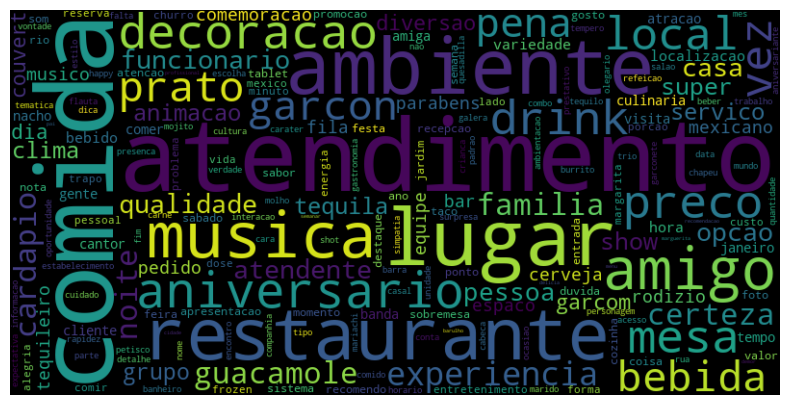

In [15]:
from wordcloud import WordCloud
wordcloud_text = ' '.join(df_reviews["Review_Topic"].astype(str))

wordcloud = WordCloud(width=800, height=400, random_state=15, max_font_size=110, max_words=200, collocations=False).generate(wordcloud_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### BERTopic

Using the standard BERTopic parameters, we will obtain the topics, from the most frequent to the least frequent.
- If we want to visualize the frequency of each topic, we can use ```get_topic_freq()``` to obtain the values.
- If we want to visualize the information of all the topics obtained, we can use ```get_topic_info()``` to obtain the number of documents that are related to each topic and its name, in addition to their textual representations.
- If we want to visualize the information of a specific topic, we can use ```get_topic()``` to obtain the words that belong to the topic and their c-TF-IDF _scores_, that is, a numerical representation of how frequent and unique that word is for the document.

It is worth remembering that the topic number **-1** refers to all outliers and should normally be ignored.

In [25]:
%%time
import numpy as np
from umap import UMAP

MAX_LEN = 175
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

topic_model = BERTopic(language="portuguese", calculate_probabilities=True, verbose=True, min_topic_size=50)
topics, probs = topic_model.fit_transform(doc_comments)

2024-09-01 13:25:46,231 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/90 [00:00<?, ?it/s]

2024-09-01 13:26:27,570 - BERTopic - Embedding - Completed ✓
2024-09-01 13:26:27,570 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-01 13:26:53,020 - BERTopic - Dimensionality - Completed ✓
2024-09-01 13:26:53,024 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-01 13:26:53,481 - BERTopic - Cluster - Completed ✓
2024-09-01 13:26:53,510 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-09-01 13:26:53,609 - BERTopic - Representation - Completed ✓


CPU times: total: 3min 6s
Wall time: 1min 8s


In [26]:
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,135,-1_garcons_casa_comida_familia,"[garcons, casa, comida, familia, burrito, aten...","[lugar atendimento garcons, lugar atendimento ..."
1,0,598,0_lugar_atendimento_aniversario_amigo,"[lugar, atendimento, aniversario, amigo, ambie...",[lugar decoracao atendimento lugar amigo famil...
2,1,562,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim..."
3,2,502,2_musica_comida_musico_ambiente,"[musica, comida, musico, ambiente, atendimento...","[comida musica atendimento, musica ambiente at..."
4,3,365,3_restaurante_atendimento_comida_prato,"[restaurante, atendimento, comida, prato, deco...","[atendimento restaurante comida, restaurante, ..."


In [27]:
topic_model.get_topic_freq().head()

,Topic,Count
3,0,598
0,1,562
1,2,502
5,3,365
4,4,272


In [28]:
topic_model.get_topic(3)

[('restaurante', 0.22991872609451186),
 ('atendimento', 0.06677947338241826),
 ('comida', 0.056898203042975506),
 ('prato', 0.0468555360456295),
 ('decoracao', 0.04259168910976397),
 ('qualidade', 0.03608896948944255),
 ('vez', 0.033576073597469704),
 ('ambiente', 0.033450233675827654),
 ('mesa', 0.03172519328979048),
 ('bar', 0.03163062238980896)]

In [29]:
topic_model.visualize_topics()

In [30]:
topic_model.visualize_documents(doc_comments)

#### Visualização dos tópicos

In [31]:
topic_model.visualize_barchart(top_n_topics=20)

In [32]:
topic_model.visualize_hierarchy()

#### DataFrame with complete information

In [33]:
df_topics = df_reviews.copy()

df_topics["Topics"] = topics

topic_name = freq.drop(columns=["Count"]).rename(columns={"Topic": "Topics", "Name": "Names"})
df_topics = df_topics.merge(topic_name, how="left")

df_topics.head()

,Date,Review,Review_Topic,Review_Entity,Topics,Names,Representation,Representative_Docs
0,4 de dezembro de 2023,Atendimento maravilhoso! Matheus foi muito ate...,atendimento matheus playlist atendente,Atendimento maravilhoso! Matheus foi muito ate...,1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim..."
1,2 de dezembro de 2023,Gostei muito dos pratos e do atendimento. Muit...,prato atendimento comida certeza,Gostei muito dos pratos e do atendimento. Muit...,1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim..."
2,1 de dezembro de 2023,"Eu amei, é a melhor cozinha mexicana que eu já...",cozinha espaco decoracao caso atendimento,"Eu amei, e a melhor cozinha mexicana que eu ja...",1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim..."
3,29 de novembro de 2023,"Ótimo ambiente e decoração, funcionários prest...",ambiente funcionario musica,"Otimo ambiente e decoracao, funcionarios prest...",2,2_musica_comida_musico_ambiente,"[musica, comida, musico, ambiente, atendimento...","[comida musica atendimento, musica ambiente at..."
4,27 de novembro de 2023,"Amomamos o atendimento do Matheus e do, tudo ó...",atendimento atendimento comida,"Amomamos o atendimento do Matheus e do, tudo o...",1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim..."


# Sentiment Analysis

Using a public pre-trained model based on BERT, we will extract sentiment information from each of the reviews.

In [34]:
%%time

model = AutoModelForSequenceClassification.from_pretrained('lxyuan/distilbert-base-multilingual-cased-sentiments-student')
tokenizer = AutoTokenizer.from_pretrained('lxyuan/distilbert-base-multilingual-cased-sentiments-student', do_lower_case=False)
sentiment_task = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, return_all_scores=True)

CPU times: total: 2.58 s
Wall time: 3.07 s


#### Classifying assessments and saving results in DataFrame

To extract sentiments and save the information about the values ​​in the DataFrame, we will use two functions:
- To capture sentiments and save them in the DataFrame in the standard way of delivering results, we will first call the process pipeline, called ```sentiment_task``` and store the values ​​in a column called "Sentiments".
- Once this is done, we will separate the values ​​according to sentiment and store each of them in the final DataFrame using the ```extract_sentiment_scores()``` function.

In [35]:
def extract_sentiment_scores(predictions, sentiment_label):
    if isinstance(predictions, list) and predictions:
        for item in predictions[0]:
            if item['label'] == sentiment_label:
                return item['score']
    return 0

In [36]:
%%time

df_topics["Sentiments"] = df_topics["Review"].apply(lambda x: sentiment_task(x))

CPU times: total: 22min
Wall time: 4min 12s


In [37]:
df_topics["Positive"] = df_topics["Sentiments"].apply(lambda x: extract_sentiment_scores(x, 'positive'))
df_topics["Neutral"] = df_topics["Sentiments"].apply(lambda x: extract_sentiment_scores(x, 'neutral'))
df_topics["Negative"] = df_topics["Sentiments"].apply(lambda x: extract_sentiment_scores(x, 'negative'))

df_topics = df_topics.drop(columns=["Sentiments"])

In [38]:
df_topics.head()

,Date,Review,Review_Topic,Review_Entity,Topics,Names,Representation,Representative_Docs,Positive,Neutral,Negative
0,4 de dezembro de 2023,Atendimento maravilhoso! Matheus foi muito ate...,atendimento matheus playlist atendente,Atendimento maravilhoso! Matheus foi muito ate...,1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.989543,0.006004,0.004453
1,2 de dezembro de 2023,Gostei muito dos pratos e do atendimento. Muit...,prato atendimento comida certeza,Gostei muito dos pratos e do atendimento. Muit...,1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.626670,0.077070,0.296260
2,1 de dezembro de 2023,"Eu amei, é a melhor cozinha mexicana que eu já...",cozinha espaco decoracao caso atendimento,"Eu amei, e a melhor cozinha mexicana que eu ja...",1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.967855,0.019304,0.012841
3,29 de novembro de 2023,"Ótimo ambiente e decoração, funcionários prest...",ambiente funcionario musica,"Otimo ambiente e decoracao, funcionarios prest...",2,2_musica_comida_musico_ambiente,"[musica, comida, musico, ambiente, atendimento...","[comida musica atendimento, musica ambiente at...",0.940317,0.025686,0.033997
4,27 de novembro de 2023,"Amomamos o atendimento do Matheus e do, tudo ó...",atendimento atendimento comida,"Amomamos o atendimento do Matheus e do, tudo o...",1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.979101,0.012174,0.008725


Once this is done, we will calculate the average of the values ​​of each of the three sentiments for the topics in question and, at the end of everything, we will see which is the highest value among the three to define the final sentiment for the topic analyzed.

In [40]:
df_topic_sentiment = df_topics.groupby('Topics').agg({'Neutral': 'mean', 'Positive': 'mean', 'Negative': 'mean'})
df_topic_sentiment = df_topic_sentiment.reset_index()
df_topic_sentiment.head()

,Topics,Neutral,Positive,Negative
0,-1,0.042968,0.849756,0.107276
1,0,0.044291,0.824145,0.131563
2,1,0.044476,0.837746,0.117779
3,2,0.041983,0.870644,0.087373
4,3,0.056442,0.805179,0.138379


In [41]:
score_cols = ['Neutral', 'Positive', 'Negative']
df_topic_sentiment['Highest Score'] = df_topic_sentiment[score_cols].max(axis=1)

def get_sentiment(row):
    if row['Positive'] == row['Highest Score']:
        return 'Positive'
    elif row['Negative'] == row['Highest Score']:
        return 'Negative'
    else:
        return 'Neutral'

df_topic_sentiment['Topic Sentiment'] = df_topic_sentiment.apply(get_sentiment, axis=1)
df_topic_sentiment.head()

,Topics,Neutral,Positive,Negative,Highest Score,Topic Sentiment
0,-1,0.042968,0.849756,0.107276,0.849756,Positive
1,0,0.044291,0.824145,0.131563,0.824145,Positive
2,1,0.044476,0.837746,0.117779,0.837746,Positive
3,2,0.041983,0.870644,0.087373,0.870644,Positive
4,3,0.056442,0.805179,0.138379,0.805179,Positive


In [42]:
score_cols = ['Neutral', 'Positive', 'Negative']
df_topics['Highest Score'] = df_topics[score_cols].max(axis=1)

def get_sentiment(row):
    if row['Positive'] == row['Highest Score']:
        return 'Positive'
    elif row['Negative'] == row['Highest Score']:
        return 'Negative'
    else:
        return 'Neutral'
df_topics['Sentiment'] = df_topics.apply(get_sentiment, axis=1)
df_topics.head()

,Date,Review,Review_Topic,Review_Entity,Topics,Names,Representation,Representative_Docs,Positive,Neutral,Negative,Highest Score,Sentiment
0,4 de dezembro de 2023,Atendimento maravilhoso! Matheus foi muito ate...,atendimento matheus playlist atendente,Atendimento maravilhoso! Matheus foi muito ate...,1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.989543,0.006004,0.004453,0.989543,Positive
1,2 de dezembro de 2023,Gostei muito dos pratos e do atendimento. Muit...,prato atendimento comida certeza,Gostei muito dos pratos e do atendimento. Muit...,1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.626670,0.077070,0.296260,0.626670,Positive
2,1 de dezembro de 2023,"Eu amei, é a melhor cozinha mexicana que eu já...",cozinha espaco decoracao caso atendimento,"Eu amei, e a melhor cozinha mexicana que eu ja...",1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.967855,0.019304,0.012841,0.967855,Positive
3,29 de novembro de 2023,"Ótimo ambiente e decoração, funcionários prest...",ambiente funcionario musica,"Otimo ambiente e decoracao, funcionarios prest...",2,2_musica_comida_musico_ambiente,"[musica, comida, musico, ambiente, atendimento...","[comida musica atendimento, musica ambiente at...",0.940317,0.025686,0.033997,0.940317,Positive
4,27 de novembro de 2023,"Amomamos o atendimento do Matheus e do, tudo ó...",atendimento atendimento comida,"Amomamos o atendimento do Matheus e do, tudo o...",1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.979101,0.012174,0.008725,0.979101,Positive


In [43]:
topic_sentiment_counts = df_topics['Sentiment'].value_counts()

for topic_sentiment, count in topic_sentiment_counts.items():
    print("Valor:", topic_sentiment)
    print("Frequência:", count)
    print()

Valor: Positive
Frequência: 2648

Valor: Negative
Frequência: 218

Valor: Neutral
Frequência: 6



In [45]:
df_topic_sentiment.to_csv('guacamole_topics_sentiment.csv', index=False)

# Named Entity Extraction

In [46]:
model_ner = AutoModelForTokenClassification.from_pretrained('51la5/roberta-large-NER')
tokenizer_ner = AutoTokenizer.from_pretrained('51la5/roberta-large-NER', do_lower_case=False)
ner_task = pipeline("ner", model=model_ner, tokenizer=tokenizer_ner)

Some weights of the model checkpoint at 51la5/roberta-large-NER were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
def classify_ner(text):
    """
    Token classification function using a pretrained model.

    Parameters:
    - text: Input text to be tokenized and classified.

    Returns:
    List of tuples containing predicted pairs (token, label) for the input text.

    Example:
    Input:  "Julia is tired of living in London."
    Output: [('Julia', 'B-PESSOA'), ('is', 'O'), ('tired', 'O'), ('of', 'O'),
            ('living', 'O'), ('in', 'O'), ('London', 'B-LOCAL'), ('.', 'O')]
    """

    inputs = tokenizer_ner(text, max_length=512, truncation=True, return_tensors="pt")
    tokens = inputs.tokens()

    outputs = model_ner(**inputs).logits
    predictions = torch.argmax(outputs, dim=2)

    results = []

    for token, prediction in zip(tokens, predictions[0].numpy()):
        label = model_ner.config.id2label.get(prediction, 'O')
        if label != 'O':
            results.append((token, label))

    return results

In [48]:
%%time

df_topics["Token Predictions"] = df_topics["Review_Entity"].apply(classify_ner)

CPU times: total: 2h 10min 45s
Wall time: 2h 4min 31s


In [49]:
def merge_tokens(token_predictions):
    """
    Function to merge consecutive tokens that start with "_" and have the same label.

    Parameters:
    - token_predictions: List of tuples containing predicted pairs (token, label).

    Returns:
    List of merged tuples where consecutive tokens starting with "_"
    and having the same label are combined.

    Example:
    Input:  [('▁Mathe', 'I-PER'), ('us', 'I-PER')]
    Output: [('▁Matheus', 'I-PER')]
    """

    merged_results = []
    current_token = ""
    current_label = ""

    for token, label in token_predictions:
        if token.startswith("▁"):
            if current_token:
                merged_results.append((current_token, current_label))
            current_token = token[1:]
            current_label = label
        else:
            current_token += token
            current_label = label

    if current_token:
        merged_results.append((current_token, current_label))

    return merged_results

In [50]:
%%time

df_topics["Token Predictions Corrected"] = df_topics["Token Predictions"].apply(merge_tokens)

CPU times: total: 15.6 ms
Wall time: 258 ms


In [51]:
token_predictions_corrected = df_topics["Token Predictions Corrected"]

flat_list = [item for sublist in token_predictions_corrected for item in sublist]

counter = Counter(flat_list)

most_common_elements = counter.most_common(20)

most_common_elements

[(('mexicana', 'I-MISC'), 335),
 (('mexicano', 'I-MISC'), 137),
 (('Rio', 'I-LOC'), 86),
 (('Mexico', 'I-LOC'), 67),
 (('Guacamole', 'I-ORG'), 65),
 (('Barra', 'I-LOC'), 53),
 (('Guacamole', 'I-LOC'), 53),
 (('de', 'I-LOC'), 35),
 (('Janeiro', 'I-LOC'), 30),
 (('Jardim', 'I-LOC'), 28),
 (('<s>', 'I-LOC'), 27),
 (('Gabriel', 'I-PER'), 27),
 (('Botanico', 'I-LOC'), 26),
 (('Maria', 'I-MISC'), 23),
 (('Guacamole', 'I-MISC'), 23),
 (('da', 'I-LOC'), 22),
 (('Matheus', 'I-PER'), 21),
 (('Maria', 'I-PER'), 21),
 (('Tijuca', 'I-LOC'), 20),
 (('Andre', 'I-PER'), 20)]

In [52]:
df_topics = df_topics.drop(columns=["Token Predictions"])

In [53]:
import pandas as pd
from collections import Counter

df_filtered = df_topics[df_topics["Token Predictions Corrected"].apply(lambda x: bool(x))]

def most_common_values(lst, n=5):
    counter = Counter(lst)
    if counter:
        most_common = counter.most_common(n)
        return most_common
    else:
        return []

result = df_filtered.groupby("Topics")["Token Predictions Corrected"].agg(lambda x: most_common_values([item for sublist in x for item in sublist])).reset_index()
result.head()

,Topics,Token Predictions Corrected
0,-1,"[((mexicana, I-MISC), 11), ((mexicano, I-MISC)..."
1,0,"[((mexicana, I-MISC), 20), ((Rio, I-LOC), 12),..."
2,1,"[((mexicana, I-MISC), 77), ((mexicano, I-MISC)..."
3,2,"[((mexicana, I-MISC), 87), ((mexicano, I-MISC)..."
4,3,"[((mexicana, I-MISC), 54), ((mexicano, I-MISC)..."


In [54]:
result.to_csv('guacamole_topics_sentiments_ner.csv', index=False)

In [55]:
df_topics.head()

,Date,Review,Review_Topic,Review_Entity,Topics,Names,Representation,Representative_Docs,Positive,Neutral,Negative,Highest Score,Sentiment,Token Predictions Corrected
0,4 de dezembro de 2023,Atendimento maravilhoso! Matheus foi muito ate...,atendimento matheus playlist atendente,Atendimento maravilhoso! Matheus foi muito ate...,1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.989543,0.006004,0.004453,0.989543,Positive,"[(Matheus, I-PER)]"
1,2 de dezembro de 2023,Gostei muito dos pratos e do atendimento. Muit...,prato atendimento comida certeza,Gostei muito dos pratos e do atendimento. Muit...,1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.626670,0.077070,0.296260,0.626670,Positive,[]
2,1 de dezembro de 2023,"Eu amei, é a melhor cozinha mexicana que eu já...",cozinha espaco decoracao caso atendimento,"Eu amei, e a melhor cozinha mexicana que eu ja...",1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.967855,0.019304,0.012841,0.967855,Positive,"[(mexicana, I-MISC)]"
3,29 de novembro de 2023,"Ótimo ambiente e decoração, funcionários prest...",ambiente funcionario musica,"Otimo ambiente e decoracao, funcionarios prest...",2,2_musica_comida_musico_ambiente,"[musica, comida, musico, ambiente, atendimento...","[comida musica atendimento, musica ambiente at...",0.940317,0.025686,0.033997,0.940317,Positive,[]
4,27 de novembro de 2023,"Amomamos o atendimento do Matheus e do, tudo ó...",atendimento atendimento comida,"Amomamos o atendimento do Matheus e do, tudo o...",1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.979101,0.012174,0.008725,0.979101,Positive,"[(Matheus, I-PER)]"


### Complete DataFrame

In [56]:
df_info = df_topics[['Topics', 'Representation']].copy()
df_info = pd.merge(df_info, df_topic_sentiment, on='Topics', how='left')
df_info = pd.merge(df_info, result, on='Topics', how='left')
df_info = df_info.drop_duplicates(subset='Topics')

In [57]:
topic_freq = topic_model.get_topic_freq()
df_info = pd.merge(df_info, topic_freq, left_on='Topics', right_on='Topic', how='left')

In [58]:
df_info = df_info.sort_values(by='Topics')
df_info = df_info.drop(columns='Topic')

Obtenção do DataFrame completo.

In [59]:
df_info.head()

,Topics,Representation,Neutral,Positive,Negative,Highest Score,Topic Sentiment,Token Predictions Corrected,Count
2,-1,"[garcons, casa, comida, familia, burrito, aten...",0.042968,0.849756,0.107276,0.849756,Positive,"[((mexicana, I-MISC), 11), ((mexicano, I-MISC)...",135
3,0,"[lugar, atendimento, aniversario, amigo, ambie...",0.044291,0.824145,0.131563,0.824145,Positive,"[((mexicana, I-MISC), 20), ((Rio, I-LOC), 12),...",598
0,1,"[comida, atendimento, ambiente, lugar, prato, ...",0.044476,0.837746,0.117779,0.837746,Positive,"[((mexicana, I-MISC), 77), ((mexicano, I-MISC)...",562
1,2,"[musica, comida, musico, ambiente, atendimento...",0.041983,0.870644,0.087373,0.870644,Positive,"[((mexicana, I-MISC), 87), ((mexicano, I-MISC)...",502
5,3,"[restaurante, atendimento, comida, prato, deco...",0.056442,0.805179,0.138379,0.805179,Positive,"[((mexicana, I-MISC), 54), ((mexicano, I-MISC)...",365


In [60]:
df_info.to_csv('complete_guacamole_info_topics.csv', index=False)

In [61]:
df_topic_0 = df_topics[df_topics['Topics'] == 0]
df_topic_1 = df_topics[df_topics['Topics'] == 1]
df_topic_2 = df_topics[df_topics['Topics'] == 2]
df_topic_3 = df_topics[df_topics['Topics'] == 3]

In [62]:
df_topic_0.to_csv('guacamole_topic_0.csv', index=False)
df_topic_1.to_csv('guacamole_topic_1.csv', index=False)
df_topic_2.to_csv('guacamole_topic_2.csv', index=False)
df_topic_3.to_csv('guacamole_topic_3.csv', index=False)

In [63]:
sentiment_counts = df_topics.groupby(['Topics', 'Sentiment']).size().reset_index(name='count')

In [64]:
sentiment_counts.head(18)

,Topics,Sentiment,count
0,-1,Negative,7
1,-1,Positive,128
2,0,Negative,48
3,0,Neutral,1
4,0,Positive,549
5,1,Negative,42
6,1,Neutral,1
7,1,Positive,519
8,2,Negative,24
9,2,Positive,478


In [65]:
df_topics.head()

,Date,Review,Review_Topic,Review_Entity,Topics,Names,Representation,Representative_Docs,Positive,Neutral,Negative,Highest Score,Sentiment,Token Predictions Corrected
0,4 de dezembro de 2023,Atendimento maravilhoso! Matheus foi muito ate...,atendimento matheus playlist atendente,Atendimento maravilhoso! Matheus foi muito ate...,1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.989543,0.006004,0.004453,0.989543,Positive,"[(Matheus, I-PER)]"
1,2 de dezembro de 2023,Gostei muito dos pratos e do atendimento. Muit...,prato atendimento comida certeza,Gostei muito dos pratos e do atendimento. Muit...,1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.626670,0.077070,0.296260,0.626670,Positive,[]
2,1 de dezembro de 2023,"Eu amei, é a melhor cozinha mexicana que eu já...",cozinha espaco decoracao caso atendimento,"Eu amei, e a melhor cozinha mexicana que eu ja...",1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.967855,0.019304,0.012841,0.967855,Positive,"[(mexicana, I-MISC)]"
3,29 de novembro de 2023,"Ótimo ambiente e decoração, funcionários prest...",ambiente funcionario musica,"Otimo ambiente e decoracao, funcionarios prest...",2,2_musica_comida_musico_ambiente,"[musica, comida, musico, ambiente, atendimento...","[comida musica atendimento, musica ambiente at...",0.940317,0.025686,0.033997,0.940317,Positive,[]
4,27 de novembro de 2023,"Amomamos o atendimento do Matheus e do, tudo ó...",atendimento atendimento comida,"Amomamos o atendimento do Matheus e do, tudo o...",1,1_comida_atendimento_ambiente_lugar,"[comida, atendimento, ambiente, lugar, prato, ...","[ambiente atendimento comida, ambiente atendim...",0.979101,0.012174,0.008725,0.979101,Positive,"[(Matheus, I-PER)]"


In [66]:
def most_frequent_entity_by_topic(df):
    entity_by_topic = {'topic': [], 'most_frequent_entities': [], 'frequencies': []}

    groups = df.groupby('Topics')

    for group_name, group in groups:
        entity_count = {}

        for index, row in group.iterrows():
            for token_pred in row['Token Predictions Corrected']:
                entity = token_pred[0]
                entity_count[entity] = entity_count.get(entity, 0) + 1

        # Get the 5 most frequent entities and their frequencies
        most_frequent_entities = sorted(entity_count, key=entity_count.get, reverse=True)[:10]
        frequencies = [entity_count[entity] for entity in most_frequent_entities]

        # Save the entities and frequencies as comma-separated strings
        entities_string = ', '.join(most_frequent_entities)
        frequencies_string = ', '.join(map(str, frequencies))

        entity_by_topic['topic'].append(group_name)
        entity_by_topic['most_frequent_entities'].append(entities_string)
        entity_by_topic['frequencies'].append(frequencies_string)

    df_most_frequent_entity = pd.DataFrame(entity_by_topic)

    return df_most_frequent_entity

df_most_frequent_entity = most_frequent_entity_by_topic(df_topics)
df_most_frequent_entity


,topic,most_frequent_entities,frequencies
0,-1,"mexicana, mexicano, Guacamole, Rio, Maria, de,...","11, 8, 7, 4, 3, 3, 3, 3, 2, 2"
1,0,"mexicana, Rio, Gabriel, Mexico, mexicano, Guac...","20, 12, 12, 11, 10, 9, 8, 7, 7, 6"
2,1,"mexicana, mexicano, Maria, Matheus, Rio, Mexic...","77, 11, 9, 8, 8, 7, 7, 7, 7, 5"
3,2,"mexicana, mexicano, Mexico, Maria, Guacamole, ...","87, 28, 14, 10, 9, 8, 6, 6, 5, 5"
4,3,"mexicana, mexicano, Rio, Barra, de, da, Tijuca...","54, 42, 26, 15, 10, 10, 9, 8, 8, 7"
5,4,"mexicana, mexicano, Guacamole, Mexico, Rio, Ol...","15, 7, 5, 4, 4, 4, 4, 3, 3, 3"
6,5,"mexicana, mexicano, Mexico, Rio, Guacamole, <s...","36, 22, 20, 13, 8, 7, 6, 6, 6, 5"
7,6,"Guacamole, mexicana, Barra, Rio, da, Jardim, d...","83, 22, 16, 11, 9, 6, 6, 6, 5, 4"
8,7,"mexicana, Guacamole, Barra, mexicano, Matheus,...","13, 5, 3, 3, 2, 2, 2, 2, 2, 2"


In [68]:
df_most_frequent_entity.to_csv('guacamole_frequent_entities.csv', index=False)

In [69]:
def display_reviews_by_sentiment_and_topic(df, topic, output_file):
    df_topic = df[df['Topics'] == topic]

    with open(output_file, 'w') as file:
        for sentiment in ['Positive', 'Neutral', 'Negative']:
            file.write(f"Reviews with sentiment '{sentiment}' in topic '{topic}':\n")
            
            df_sentiment = df_topic[df_topic['Sentiment'] == sentiment]
            df_sentiment['Review'] = df_sentiment['Review'].str.replace('\n', ' ')
            
            for i, review_text in enumerate(df_sentiment['Review'].head(5), start=1):
                file.write(f"{i}. {review_text}\n")
            file.write('\n')

display_reviews_by_sentiment_and_topic(df_topics, 2, 'review_guacamole_2.txt')